In [15]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Agents.Prio_n_step.Prio_DQN_Agent import Prio_DQN_Agent
from Agents.Pablo.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN
from Agents.Random.random_agent import RandomAgent
from Agents.utils.actions import MORE_ACTIONS
import Agents.utils.stats_functions as sf
import hockey.hockey_env as h_env

from Agents.Tapas_en_Mallorca.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN_better_mem

from importlib import reload

In [16]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 +  563 *i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [17]:
reload(h_env)
#env_name = "../weights/prio_agent_23_02_25_n_step_4_alpha_0.4"
#env_name = "../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_10_games_only"
env_name = "../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)
#env = gym.make("CartPole-v1", render_mode = "rgb_array")

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Adaptative_Dueling_Double_DQN_better_mem(state_space, action_space, seed = seed, eps = 0.01,use_dueling = True, use_double = True, use_noisy = True, use_prio = True ,learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 4, env = env, use_more_actions = USE_MORE_ACTIONS)
#agent = Adaptative_Dueling_Double_DQN(state_space, action_space, seed = seed,use_dueling = True, use_double = True, use_noisy = True ,eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], env = env, use_more_actions = USE_MORE_ACTIONS)
#agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 4, env = env, use_more_actions = USE_MORE_ACTIONS)
agent.Q.load(env_name, name= "most_recent")

Dueling Network Architecture with Noisy Layers
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: NoisyLinear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling Network Architecture with Noisy Layers
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: NoisyLinear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/weights/most_recent.pth


/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/goon/studium/hockey-en-mallorca/src/hockey-env/Agents/Tapas_en_Mallorca/Adaptative_Dueling_Double_DQN/QFunction.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a futu

In [18]:
stats, losses = sf.load_stats(env_name)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/returns_plot.png


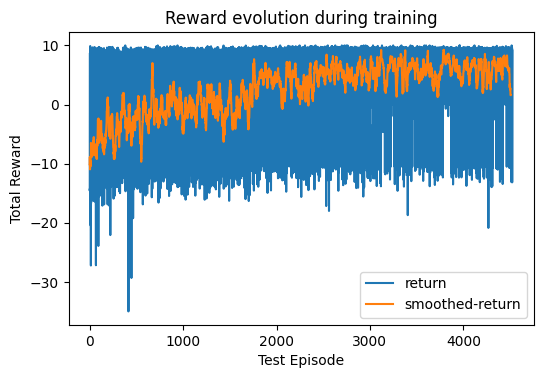

In [19]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/losses_plot.png


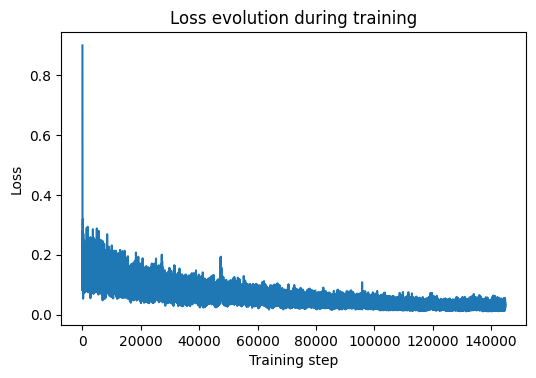

In [20]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/beta_evolution.png


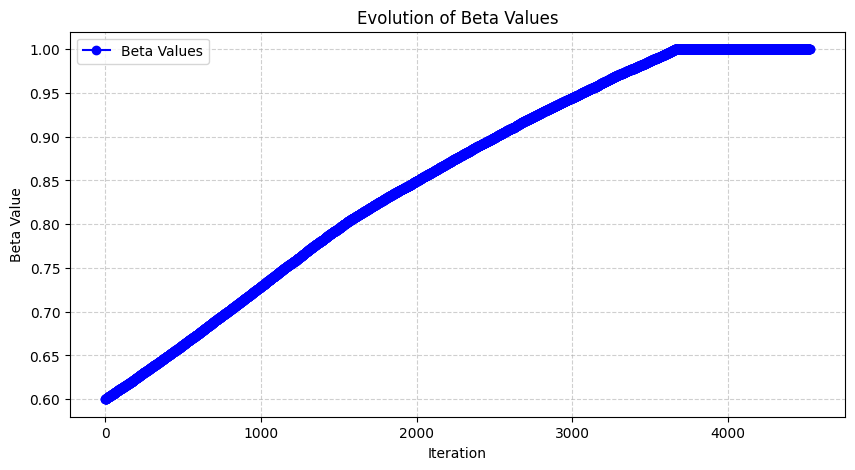

In [21]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/epsilon_evolution.png


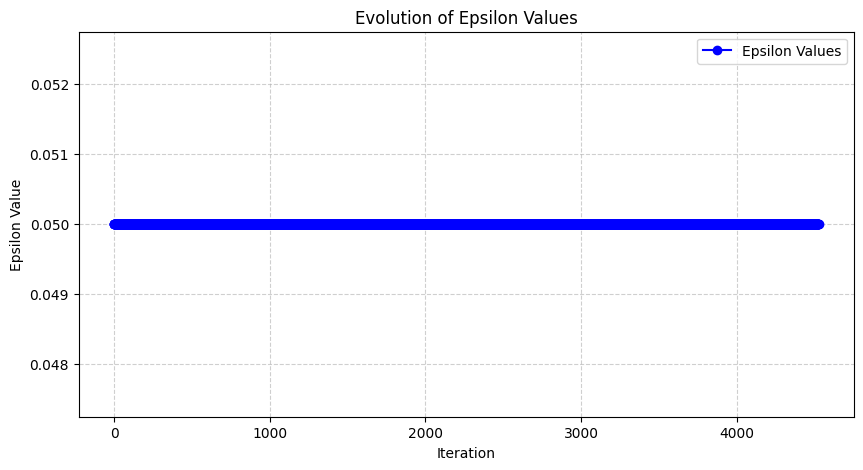

In [22]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/match_evolution.png


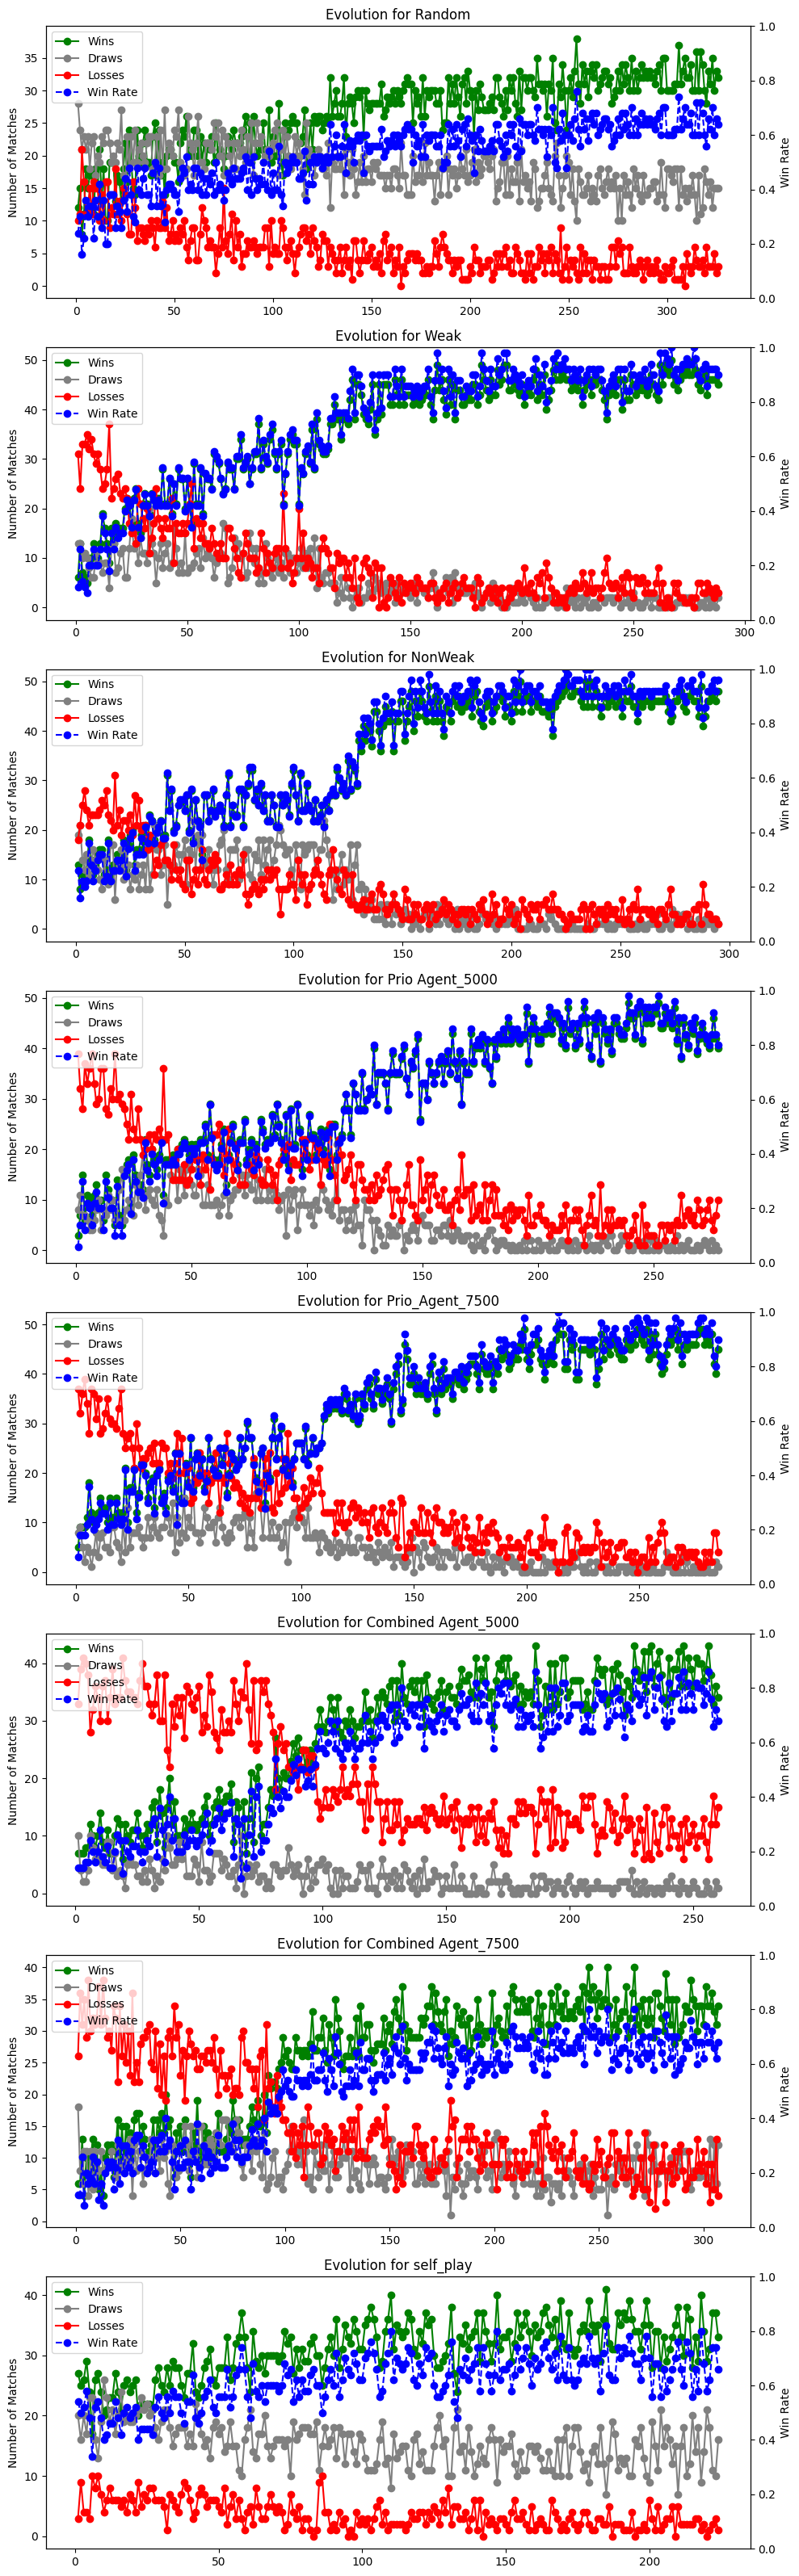

In [23]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history,  [
    "Random",
    "Weak",
    "NonWeak",
    "Prio Agent_5000",
    "Prio_Agent_7500",
    "Combined Agent_5000",
    "Combined Agent_7500",
    "self_play",
], 50)

#sf.plot_match_evolution_by_chunks(env_name, match_history,  ["Weak", "NonWeak" ],50)


In [24]:
def test_agent(agent = agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "prio_agent", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  
    won_games = 0
    lost_games = 0
    tied_games = 0
    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
       #state = env.reset(seed = seed)
        env.action_space.seed(seed = SEEDS_TEST[episode])
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            frame = env.render(mode = "rgb_array")
            if frame is not None:
                frames.append(frame)

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, _ = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        test_rewards.append(total_reward)
        won = env.winner == 1
        if won:
            won_games += 1
        tie = env.winner == 0
        if tie:
            tied_games += 1
        lost = not won and not tie
        if lost:
            lost_games += 1
        string = "Won" if won else "Tie" if tie else "Lost"
        print(f"Test Episode {episode+1}, Total Reward: {total_reward}", string)
       
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    env.close()
    winrate = won_games / test_episodes
    tie_rate = tied_games / test_episodes
    loss_rate = lost_games / test_episodes
    print(f"Winrate: {winrate}, Tie Rate: {tie_rate}, Loss Rate: {loss_rate}")
    results_name = f"test_results_{test_name}"
    sf.save_test_results(env_name, test_rewards, name = results_name)

Test Episode 1, Total Reward: 9.04203927136297 Won
Test Episode 2, Total Reward: 9.622333696694202 Won
Test Episode 3, Total Reward: 0.0 Tie
Test Episode 4, Total Reward: 8.863803902214078 Won
Test Episode 5, Total Reward: 0.0 Tie
Test Episode 6, Total Reward: 9.318725074880708 Won
Test Episode 7, Total Reward: -1.0596202786580355 Tie
Test Episode 8, Total Reward: 8.134134620947709 Won
Test Episode 9, Total Reward: -11.771828298745191 Lost
Test Episode 10, Total Reward: 9.01668706458533 Won
Winrate: 0.6, Tie Rate: 0.3, Loss Rate: 0.1
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/test_results_random_vs_prio_agent.png


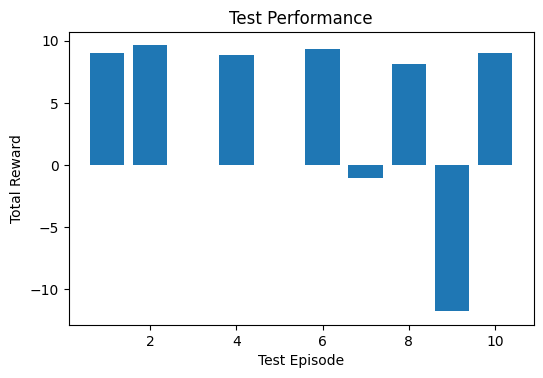

In [25]:
test_agent()

Test Episode 1, Total Reward: 9.690489881420856 Won
Test Episode 2, Total Reward: 9.636350232660929 Won
Test Episode 3, Total Reward: 9.717887582070764 Won
Test Episode 4, Total Reward: 8.675384237875155 Won
Test Episode 5, Total Reward: 9.928928718312585 Won
Test Episode 6, Total Reward: 9.30517737736487 Won
Test Episode 7, Total Reward: 9.071911929605601 Won
Test Episode 8, Total Reward: 9.120600614806188 Won
Test Episode 9, Total Reward: 9.855864075234686 Won
Test Episode 10, Total Reward: 8.842760720611729 Won
Winrate: 1.0, Tie Rate: 0.0, Loss Rate: 0.0
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/test_results_weak_vs_prio_agent.png


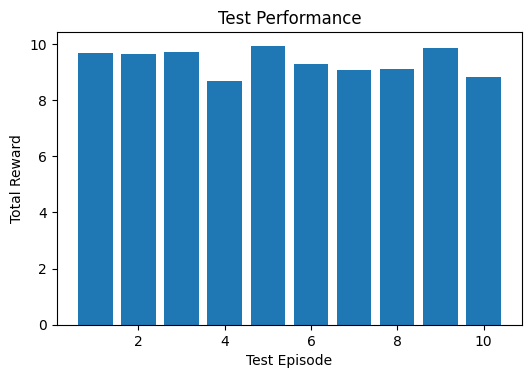

In [26]:
test_agent(opponent = h_env.BasicOpponent(weak=True), opponent_name = "weak", agent_name = "prio_agent")



Test Episode 1, Total Reward: 8.399740149692793 Won
Test Episode 2, Total Reward: 9.60796290158836 Won
Test Episode 3, Total Reward: 8.736594267083506 Won
Test Episode 4, Total Reward: 8.756276019920671 Won
Test Episode 5, Total Reward: 8.858049678982145 Won
Test Episode 6, Total Reward: 7.8190871263675055 Won
Test Episode 7, Total Reward: 9.39152372243871 Won
Test Episode 8, Total Reward: 9.114904667916386 Won
Test Episode 9, Total Reward: 8.656593905980333 Won
Test Episode 10, Total Reward: 8.961826466213004 Won
Winrate: 1.0, Tie Rate: 0.0, Loss Rate: 0.0
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/test_results_non_weak_vs_prio_agent.png


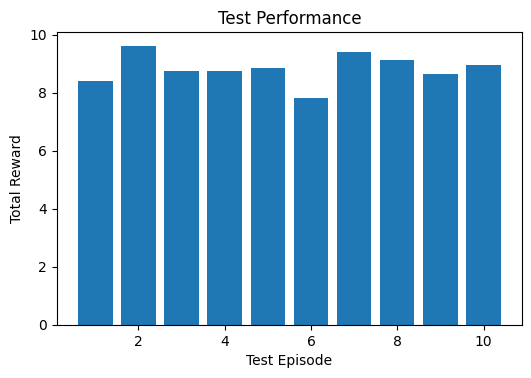

In [27]:
test_agent(opponent = h_env.BasicOpponent(weak=False), opponent_name = "non_weak", agent_name = "prio_agent")

Test Episode 1, Total Reward: 9.048475038075974
Test Episode 2, Total Reward: -11.11223760565912
Test Episode 3, Total Reward: -11.208595203712665
Test Episode 4, Total Reward: 8.992347591791674
Test Episode 5, Total Reward: -10.579147056650656
Test Episode 6, Total Reward: 9.021182843938503
Test Episode 7, Total Reward: -10.922897201816575
Test Episode 8, Total Reward: 8.996424338892488
Test Episode 9, Total Reward: 9.18079969540396
Test Episode 10, Total Reward: 9.007672664085398
Plot saved at ../weights/Noisy_Dueling_Double_DQN_Prio_n_step_4_bigger_nn/stats/plots/test_results_selfplay.png


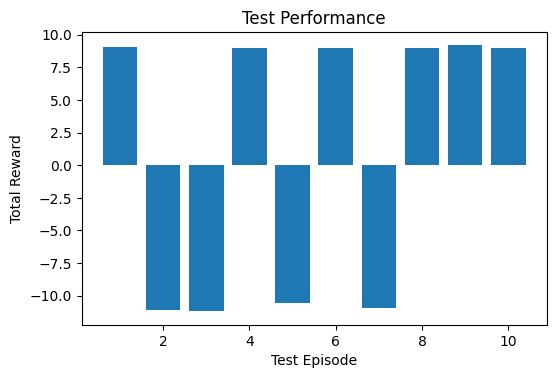

In [28]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)
#opponent.Q.load(env_name, name = "episode_1500")

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    env.action_space.seed(seed)
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.act(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")